In [5]:
#pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import chardet

with open('sales_data2.csv', 'rb') as f:
    result = chardet.detect(f.read())
    detected_encoding = result['encoding']
    print(f"Detected encoding: {detected_encoding}")

df = pd.read_csv('sales_data2.csv', encoding=detected_encoding)
df.to_csv('sales_data2.csv', encoding='utf-8', index=False)

df = pd.read_csv('sales_data2.csv', encoding='utf-8')

df.head()

Detected encoding: utf-8


,Order Date,Order ID,Product,Product_ean,catégorie,Purchase Address,Quantity Ordered,Price Each,Cost price,turnover,margin
0,2019-01-22 21:25:00,141234,iPhone,5.638009e+12,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000
1,2019-01-28 14:15:00,141235,Lightning Charging Cable,5.563320e+12,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750
2,2019-01-17 13:33:00,141236,Wired Headphones,2.113973e+12,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900
3,2019-01-05 20:33:00,141237,27in FHD Monitor,3.069157e+12,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965
4,2019-01-25 11:59:00,141238,Wired Headphones,9.692681e+12,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950


In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['MONTH'] = df['Order Date'].dt.month
df['DAY'] = df['Order Date'].dt.day
df['YEAR'] = df['Order Date'].dt.year
df['TIME'] = df['Order Date'].dt.time

# Create automated index for categories
df['CATEGORY_ID'] = pd.factorize(df['catégorie'])[0] + 1

# Create automated index for products
df['PRODUCT_ID'] = pd.factorize(df['Product'])[0] + 1

# Drop the Product_ean column if it exists
if 'Product_ean' in df.columns:
    df = df.drop('Product_ean', axis=1)

df


,Order Date,Order ID,Product,catégorie,Purchase Address,Quantity Ordered,Price Each,Cost price,turnover,margin,MONTH,DAY,YEAR,TIME,CATEGORY_ID,PRODUCT_ID
0,2019-01-22 21:25:00,141234,iPhone,Vêtements,"944 Walnut St, Boston, MA 02215",1,700.00,231.0000,700.00,469.0000,1,22,2019,21:25:00,1,1
1,2019-01-28 14:15:00,141235,Lightning Charging Cable,Alimentation,"185 Maple St, Portland, OR 97035",1,14.95,7.4750,14.95,7.4750,1,28,2019,14:15:00,2,2
2,2019-01-17 13:33:00,141236,Wired Headphones,Vêtements,"538 Adams St, San Francisco, CA 94016",2,11.99,5.9950,23.98,11.9900,1,17,2019,13:33:00,1,3
3,2019-01-05 20:33:00,141237,27in FHD Monitor,Sports,"738 10th St, Los Angeles, CA 90001",1,149.99,97.4935,149.99,52.4965,1,5,2019,20:33:00,3,4
4,2019-01-25 11:59:00,141238,Wired Headphones,Électronique,"387 10th St, Austin, TX 73301",1,11.99,5.9950,11.99,5.9950,1,25,2019,11:59:00,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185945,2019-12-11 20:58:00,319666,Lightning Charging Cable,Électronique,"14 Madison St, San Francisco, CA 94016",1,14.95,7.4750,14.95,7.4750,12,11,2019,20:58:00,4,2
185946,2019-12-01 12:01:00,319667,AA Batteries (4-pack),Électronique,"549 Willow St, Los Angeles, CA 90001",2,3.84,1.9200,7.68,3.8400,12,1,2019,12:01:00,4,13
185947,2019-12-09 06:43:00,319668,Vareebadd Phone,Alimentation,"273 Wilson St, Seattle, WA 98101",1,400.00,132.0000,400.00,268.0000,12,9,2019,06:43:00,2,12
185948,2019-12-03 10:39:00,319669,Wired Headphones,Alimentation,"778 River St, Dallas, TX 75001",1,11.99,5.9950,11.99,5.9950,12,3,2019,10:39:00,2,3


In [9]:
# Xarxa Neuronal amb TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Preparar les dades
df_nn = df.copy()

# Drop les columnes categòriques originals ja que tenim IDs
df_nn = df_nn.drop(['catégorie', 'Product'], axis=1)

# Encode columnes categòriques restants
categorical_cols_nn = df_nn.select_dtypes(include=['object']).columns
label_encoders_nn = {}
for col in categorical_cols_nn:
    le = LabelEncoder()
    df_nn[col] = le.fit_transform(df_nn[col].astype(str))
    label_encoders_nn[col] = le

# Separar features i target
X_nn = df_nn.drop(['turnover', 'margin', 'Order Date'], axis=1)
y_nn = df_nn['turnover']

# Split train/test
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

# Normalitzar les dades (important per xarxes neuronals!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nn)
X_test_scaled = scaler.transform(X_test_nn)

print(f"Nombre de features: {X_train_scaled.shape[1]}")
print(f"Train samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")


Nombre de features: 11
Train samples: 148760
Test samples: 37190


In [10]:
# Crear el model de Xarxa Neuronal
model_nn = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Output layer per regressió
])

# Compilar el model
model_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Veure l'arquitectura del model
model_nn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,#canviar a 5, 50 és per fer overfitting
    restore_best_weights=True
)
#descomentar, és per evitar aturar abans de l'overfitting
#reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=50,
#     min_lr=0.00001
# )

history = model_nn.fit(
    X_train_scaled, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],#, reduce_lr],
    verbose=1
)


Epoch 1/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 6270.1401 - mae: 30.9894 - mse: 6270.1401 - val_loss: 214.9708 - val_mae: 7.9253 - val_mse: 214.9708
Epoch 2/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2231.7625 - mae: 20.6255 - mse: 2231.7625 - val_loss: 180.0810 - val_mae: 7.3951 - val_mse: 180.0810
Epoch 3/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1963.6838 - mae: 18.6562 - mse: 1963.6838 - val_loss: 310.6972 - val_mae: 9.4320 - val_mse: 310.6972
Epoch 4/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1782.1305 - mae: 17.5172 - mse: 1782.1305 - val_loss: 170.1240 - val_mae: 7.5380 - val_mse: 170.1240
Epoch 5/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1664.5546 - mae: 16.8192 - mse: 1664.5546 - val_loss: 551.5011 - val_mae: 11.2933 - val_mse: 551.5011
Epoch 6/100
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1496.6548 - mae: 15.8644 - mse: 1496.6548 - val_loss: 835.3705 - val_mae: 13.9554 - val_mse: 835.3705
Epoch 7/100
37

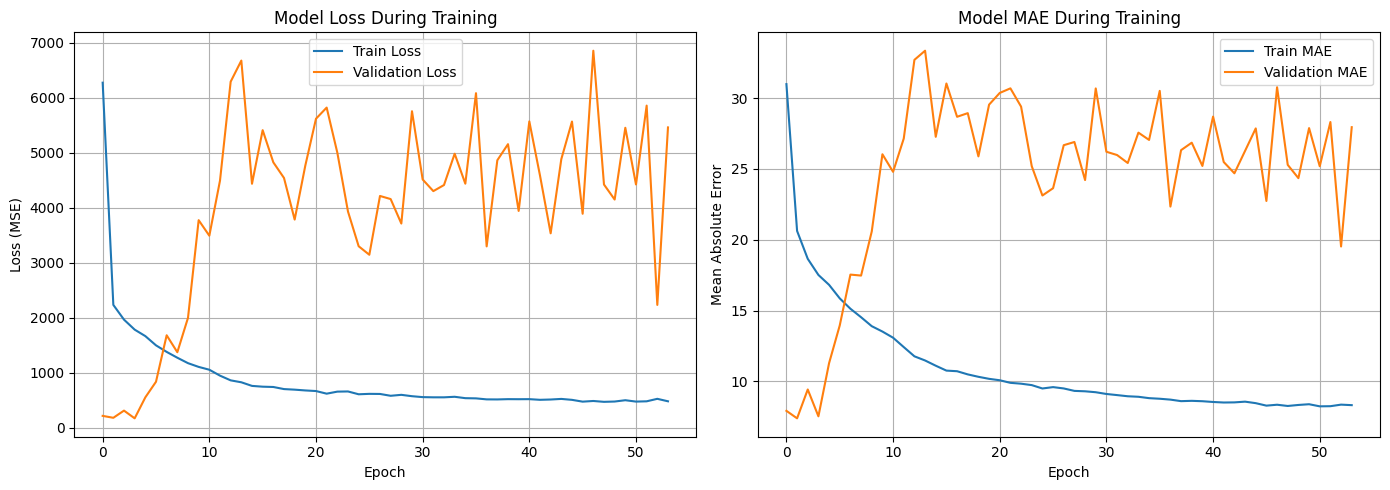

In [12]:
# Visualitzar el procés d'entrenament
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Avaluar el model
y_pred_nn = model_nn.predict(X_test_scaled).flatten()

# Calcular mètriques
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test_nn, y_pred_nn)
r2_nn = r2_score(y_test_nn, y_pred_nn)

print("=" * 50)
print("XARXA NEURONAL - Resultats")
print("=" * 50)
print(f'MSE:  {mse_nn:.2f}')
print(f'RMSE: {rmse_nn:.2f}')
print(f'MAE:  {mae_nn:.2f}')
print(f'R² Score: {r2_nn:.4f}')
print("=" * 50)


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
XARXA NEURONAL - Resultats
MSE:  247.90
RMSE: 15.74
MAE:  7.63
R² Score: 0.9978


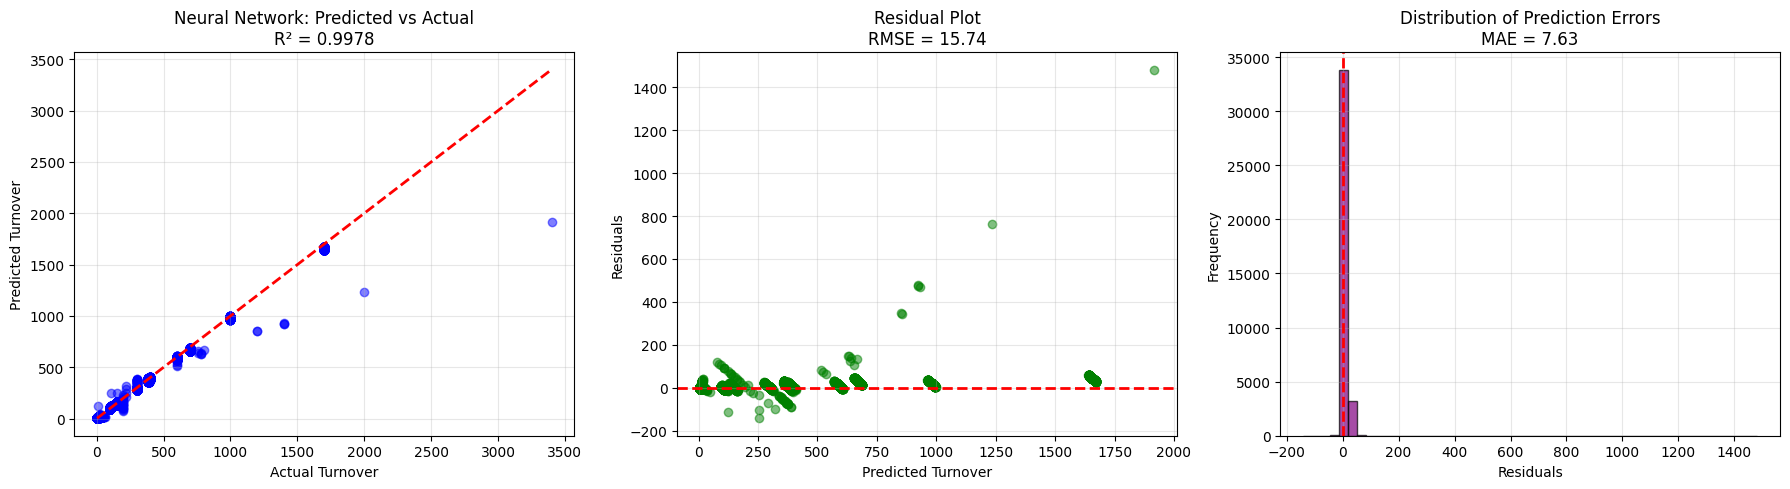

In [17]:
# Visualitzar resultats de la Xarxa Neuronal
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test_nn, y_pred_nn, alpha=0.5, color='blue')
axes[0].plot([y_test_nn.min(), y_test_nn.max()], [y_test_nn.min(), y_test_nn.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Turnover')
axes[0].set_ylabel('Predicted Turnover')
axes[0].set_title(f'Neural Network: Predicted vs Actual\nR² = {r2_nn:.4f}')
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals_nn = y_test_nn - y_pred_nn
axes[1].scatter(y_pred_nn, residuals_nn, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Turnover')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'Residual Plot\nRMSE = {rmse_nn:.2f}')
axes[1].grid(True, alpha=0.3)

# Plot 3: Distribution of Errors
axes[2].hist(residuals_nn, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Distribution of Prediction Errors\nMAE = {mae_nn:.2f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
